In [3]:
import pandas as pd
import skmob
from skmob.measures.individual import radius_of_gyration
import geopandas as gpd
from shapely.geometry import Point
from pyproj import Transformer
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df1 = pd.read_csv("yjmob100k-dataset1.csv")
grid = gpd.read_file("grid_bl_2449.geojson")

In [3]:
# lat és lon oszlopok felvétele


# cCentroidok számítása új változóba
grid_centroids = grid.copy()
grid_centroids["geometry"] = grid_centroids.centroid

# WGS84-re (lat/lon) transzformálás
grid_centroids_wgs84 = grid_centroids.to_crs(epsg=4326)

# lat/lon oszlopok
grid_centroids_wgs84["lon"] = grid_centroids_wgs84.geometry.x
grid_centroids_wgs84["lat"] = grid_centroids_wgs84.geometry.y

grid_centroids_wgs84.head()

# merge a df_test-el a cell_id alapján
df1 = df1.merge(
    grid_centroids_wgs84[["x", "y", "lat", "lon"]],
    on=["x", "y"],
    how="left"
)
df1


,uid,d,t,x,y,lat,lon
0,0,0,1,79,86,34.890534,136.927957
1,0,0,2,79,86,34.890534,136.927957
2,0,0,8,77,86,34.880518,136.927986
3,0,0,9,77,86,34.880518,136.927986
4,0,0,19,81,89,34.900579,136.942849
...,...,...,...,...,...,...,...
111535170,99999,74,38,119,77,35.090763,136.882508
111535171,99999,74,39,132,94,35.156037,136.967098
111535172,99999,74,40,124,105,35.116051,137.022050
111535173,99999,74,41,121,107,35.101038,137.032048


In [4]:
# kezdő dátum
START_DATE = pd.to_datetime("2019-09-15")

df1["datetime"] = (
    START_DATE
    + pd.to_timedelta(df1["d"], unit="D")
    + pd.to_timedelta((df1["t"] - 1) * 30, unit="m")
)

df1.head(10)


,uid,d,t,x,y,lat,lon,datetime
0,0,0,1,79,86,34.890534,136.927957,2019-09-15 00:00:00
1,0,0,2,79,86,34.890534,136.927957,2019-09-15 00:30:00
2,0,0,8,77,86,34.880518,136.927986,2019-09-15 03:30:00
3,0,0,9,77,86,34.880518,136.927986,2019-09-15 04:00:00
4,0,0,19,81,89,34.900579,136.942849,2019-09-15 09:00:00
5,0,0,20,82,88,34.905578,136.937862,2019-09-15 09:30:00
6,0,0,21,81,89,34.900579,136.942849,2019-09-15 10:00:00
7,0,0,22,81,89,34.900579,136.942849,2019-09-15 10:30:00
8,0,0,24,76,86,34.875509,136.928001,2019-09-15 11:30:00
9,0,0,25,75,82,34.870461,136.908128,2019-09-15 12:00:00


In [ ]:
# radius of gyration (RG)  (teljes időszakra)
# 8 perc futási ido

tdf = skmob.TrajDataFrame(df1, latitude='lat', longitude='lon', datetime='datetime', user_id='uid')
rg_df = radius_of_gyration(tdf)
print(rg_df.head())

100%|██████████| 100000/100000 [06:04<00:00, 274.50it/s]


   uid  radius_of_gyration
0    0           10.197634
1    1            8.954420
2    2            4.763962
3    3            8.532737
4    4            5.981758


In [ ]:

# WGS84 -> EPSG:2449 transzformáció
transformer = Transformer.from_crs("EPSG:4326", "EPSG:2449", always_xy=True)

# numpy-szerű transzformáció (gyors!)
x_m, y_m = transformer.transform(df1["lon"].values, df1["lat"].values)

df1["x_m"] = x_m
df1["y_m"] = y_m


In [ ]:

# dátum oszlop napra
df1["date"] = pd.to_datetime(df1["datetime"]).dt.date

# lat/lon -> méter koordináták (pl. EPSG:2449 Japan Plane Rectangular)
transformer = Transformer.from_crs("EPSG:4326", "EPSG:2449", always_xy=True)
df1["x_m"], df1["y_m"] = transformer.transform(df1["lon"].values, df1["lat"].values)

# napi középpont felhasználónként
daily_means = (
    df1.groupby(["uid", "date"])[["x_m", "y_m"]]
    .mean()
    .rename(columns={"x_m": "x_mean", "y_m": "y_mean"})
)

# ha volt már x_mean/y_mean, töröljük hogy ne ütközzön
df1 = df1.drop(columns=["x_mean", "y_mean"], errors="ignore")

# merge vissza a napi középpont
df1 = df1.join(daily_means, on=["uid", "date"])

# eltérés négyzete méterben
df1["sq_dist"] = (df1["x_m"] - df1["x_mean"])**2 + (df1["y_m"] - df1["y_mean"])**2

# napi Rg kiszámítása (méterben)
daily_rg_df = (
    df1.groupby(["uid", "date"])["sq_dist"]
    .mean()
    .pow(0.5)
    .reset_index(name="radius_of_gyration_m")
)


print(daily_rg_df.head())


   uid        date  radius_of_gyration_m
0    0  2019-09-15           2653.795166
1    0  2019-09-16            823.789859
2    0  2019-09-17           9503.912587
3    0  2019-09-18           5233.285665
4    0  2019-09-19           5880.781469


In [ ]:
daily_rg_df['radius_of_gyration_km'] = daily_rg_df['radius_of_gyration_m'] / 1000


daily_rg_df.drop(columns=['radius_of_gyration_m'], inplace=True)

daily_rg_df.rename(columns={'radius_of_gyration_km': 'daily_radius_of_gyration'}, inplace=True)

print(daily_rg_df.head())

   uid        date  radius_of_gyration_m  radius_of_gyration_km
0    0  2019-09-15           2653.795166               2.653795
1    0  2019-09-16            823.789859               0.823790
2    0  2019-09-17           9503.912587               9.503913
3    0  2019-09-18           5233.285665               5.233286
4    0  2019-09-19           5880.781469               5.880781
   uid        date  daily_radius_of_gyration
0    0  2019-09-15                  2.653795
1    0  2019-09-16                  0.823790
2    0  2019-09-17                  9.503913
3    0  2019-09-18                  5.233286
4    0  2019-09-19                  5.880781


In [22]:
daily_rg_df

,uid,date,daily_radius_of_gyration
0,0,2019-09-15,2.653795
1,0,2019-09-16,0.823790
2,0,2019-09-17,9.503913
3,0,2019-09-18,5.233286
4,0,2019-09-19,5.880781
...,...,...,...
7159928,99999,2019-11-24,7.564761
7159929,99999,2019-11-25,7.138384
7159930,99999,2019-11-26,7.608762
7159931,99999,2019-11-27,7.859295


In [23]:
print(daily_rg_df['daily_radius_of_gyration'].max())

60.792017152763265


In [17]:
daily_rg_df.to_csv("daily_rg.csv", index=False)

In [10]:
rg_df.to_csv("total_rg.csv", index=False)

In [13]:
rg_df = pd.read_csv("total_rg.csv")
rg_df

,uid,radius_of_gyration
0,0,10.197634
1,1,8.954420
2,2,4.763962
3,3,8.532737
4,4,5.981758
...,...,...
99995,99995,10.620674
99996,99996,8.476216
99997,99997,0.444373
99998,99998,7.921326


In [7]:
df_test = pd.read_csv("lstm_egyeni/df_test_10k.csv")

In [6]:
df_test.columns

Index(['uid', 'd', 't', 'x', 'y', 'date', 'days_of_week', 'cell_id', 'lat',
       'lon', 'temperature', 'rain', 'weather_code', 'radius_of_gyration',
       'daily_radius_of_gyration', 'is_home', 'is_workplace',
       'fraction_missing', 'unique_cells_count'],
      dtype='object')

In [8]:
df_test['radius_of_gyration'].describe()

count    1.190459e+07
mean     9.856671e+00
std      5.741605e+00
min      2.378759e-01
25%      5.621530e+00
50%      8.649910e+00
75%      1.300094e+01
max      4.323757e+01
Name: radius_of_gyration, dtype: float64

In [9]:
df_test['daily_radius_of_gyration'].describe()

count    1.190438e+07
mean     6.327175e+00
std      6.238115e+00
min      0.000000e+00
25%      1.861457e+00
50%      4.208157e+00
75%      8.740858e+00
max      5.578356e+01
Name: daily_radius_of_gyration, dtype: float64

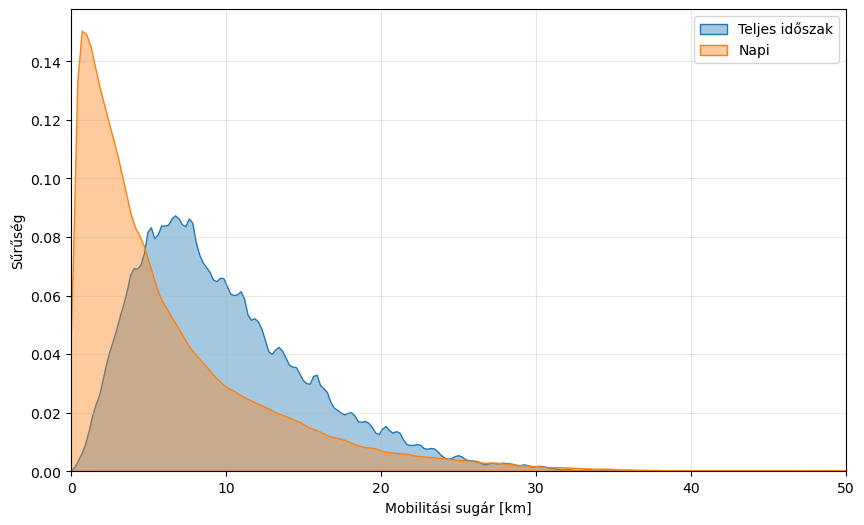

In [11]:


plt.figure(figsize=(10,6))
sns.kdeplot(df_test['radius_of_gyration'], label='Teljes időszak', fill=True, alpha=0.4)
sns.kdeplot(df_test['daily_radius_of_gyration'], label='Napi', fill=True, alpha=0.4)

plt.xlim(0, 50)
plt.xlabel('Mobilitási sugár [km]')
plt.ylabel('Sűrűség')
#plt.title('A radius of gyration eloszlása (aggregált vs. napi)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


In [ ]:
plt.figure(figsize=(8,5))
sns.boxplot(data=df_test[['radius_of_gyration', 'daily_radius_of_gyration']])
plt.ylabel('Mobilitási sugár [km]')
plt.title('Napi és összesített radius of gyration összehasonlítása')
plt.grid(axis='y', alpha=0.3)
plt.show()
